In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/laps/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
EXPERIMENT_NAME = "runs_re2"
DOMAIN = "re2"

# EXPERIMENT_NAME = "runs_clevr"
# DOMAIN = "clevr"

# EXPERIMENT_NAME = "runs_logo"
# DOMAIN = "logo"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [9]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name="library_evaluation_" + EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = "all",
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/library_evaluation_runs_re2
Available domains: ['re2']


### Tasks solved vs. search time

In [10]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

Using enumeration_timeout: 10


,time,n_solved,experiment_type,seed,iteration,split
0,0,0,baseline_dreamcoder,111,15,test
1,1,0,baseline_dreamcoder,111,15,test
2,2,0,baseline_dreamcoder,111,15,test
3,3,0,baseline_dreamcoder,111,15,test
4,4,0,baseline_dreamcoder,111,15,test
...,...,...,...,...,...,...
193,6,0,gpt_solver_stitch_namer,333,15,train
194,7,0,gpt_solver_stitch_namer,333,15,train
195,8,0,gpt_solver_stitch_namer,333,15,train
196,9,0,gpt_solver_stitch_namer,333,15,train


Text(0.5, 1.0, 're2 (test)')

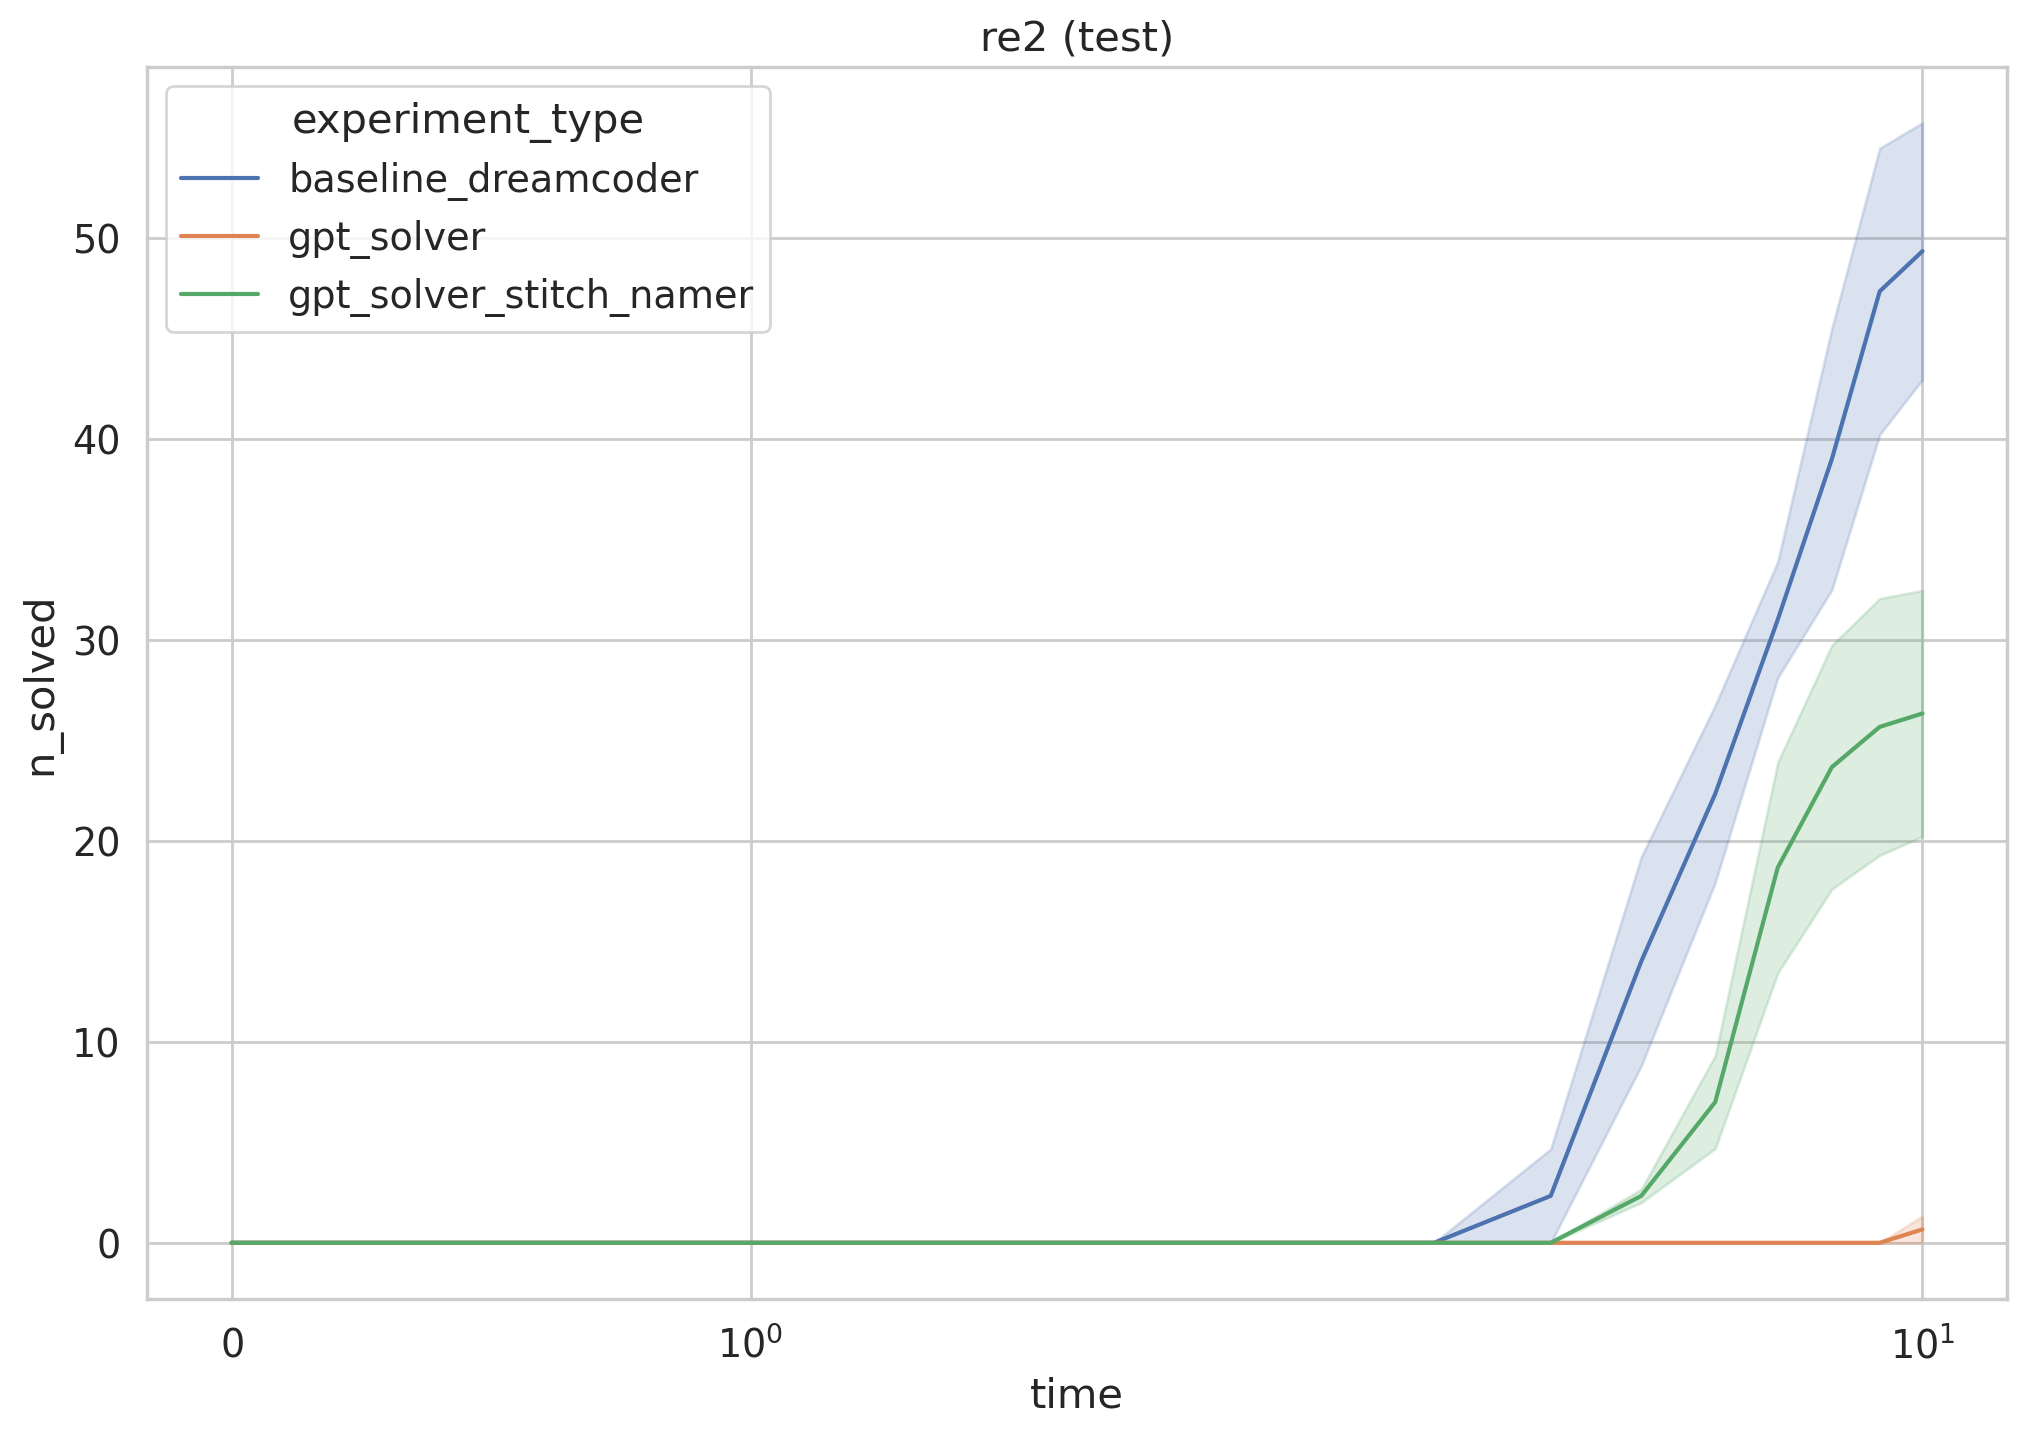

In [11]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    hue="experiment_type",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (test)")

# Analysis 2: Library abstractions

In [ ]:
df_abstractions = analyzer.get_abstractions_for_domain(DOMAIN)
df_abstractions.to_csv(f"{DOMAIN}_abstractions.csv", index=False)
df_abstractions

FileNotFoundError: [Errno 2] No such file or directory: '../experiments_iterative/outputs/runs_re2/domains/re2/gpt_solver/seed_111/gpt_solver_96/0/train/stitch_compress_output.json'

In [ ]:
ax = sns.relplot(data=df_abstractions.query("random_seed == 111").sort_values(by=["dreamcoder"], key=lambda x: x.str.len()), kind="line", col="experiment_type", y="dreamcoder", x="iteration", hue="name", size="name")
ax.set(yticklabels=[])
plt.show()

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(df_abstractions.sort_values(["experiment_type", "random_seed", "name", "iteration"])[["experiment_type", "random_seed", "name", "iteration", "arity", "compression_ratio", "dreamcoder"]])

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="compression_ratio", size="iteration")

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.title(f"{DOMAIN} compressivity of library")

In [ ]:
sns.relplot(data=df_abstractions, kind="line", errorbar="se", col="experiment_type", x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.suptitle(f"{DOMAIN} compressivity of library")

# Analysis 3: Solved programs

In [ ]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df.to_csv(f"{DOMAIN}_search_results.csv")

# re2-specific analysis

In [ ]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def task_order(keys):
    return [int(re.split(r'(\d+)', k[len("re2_test_"):])[1]) for k in keys]

def alpha_order(keys):
    return [re.split(r'(\d+)', k[len("re2_test_"):])[-1] for k in keys]

In [ ]:
ITERATION = 6
SEED = 111

df_solved = df.copy()
df_solved = df_solved.query("split == 'test'").query(f"iteration == {ITERATION}").query(f"seed == {SEED}")
df_solved = df_solved[["task", "experiment_type", "solved"]]
df_solved.groupby("experiment_type").sum()

,solved
experiment_type,
baseline_dreamcoder,219
gpt_solver,332
gpt_solver_stitch_namer,288


In [ ]:
df_solved

,task,experiment_type,solved
4437,re2_test_0_if_the_word_ends_with_s_replace_tha...,baseline_dreamcoder,True
4438,re2_test_1_if_there_is_any_letter_t_double_that,baseline_dreamcoder,False
4439,re2_test_2_if_the_word_starts_with_any_letter_...,baseline_dreamcoder,False
4440,re2_test_3_if_there_is_consonant_vowel_add_f_b...,baseline_dreamcoder,False
4441,re2_test_4_if_the_word_starts_with_any_letter_...,baseline_dreamcoder,True
...,...,...,...
70068,re2_test_495_if_there_is_vowel_n_replace_that_...,gpt_solver_stitch_namer,False
70069,re2_test_496_if_the_word_ends_with_any_letter_...,gpt_solver_stitch_namer,True
70070,re2_test_497_if_the_word_starts_with_any_lette...,gpt_solver_stitch_namer,True
70071,re2_test_498_if_there_is_vowel_r_add_u_before_...,gpt_solver_stitch_namer,False


In [ ]:
df_solved_sorted = df_solved[["task", "experiment_type", "solved"]].pivot(index="task", columns=["experiment_type"])
df_solved_sorted = df_solved_sorted.sort_values(by="task", key=task_order)

In [ ]:
def set_color(val):
    return f"color: {'green' if val else 'red'}"

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    df_display = df_solved_sorted.reset_index(level=0)
    df_display = df_display.style.set_properties(**{'text-align': 'left'}).applymap(set_color)
    display(df_display)

In [ ]:
df_vowel = df[df.task.str.contains("vowel")]
df_vowel = df_vowel.query("experiment_type == 'gpt_solver'").query(f"seed == {SEED}").query(f"iteration == {ITERATION}").query("solved")
df_vowel = df_vowel.sort_values(by="task", key=task_order)

In [ ]:
df_vowel.groupby("split").task.nunique()

In [ ]:
for _, row in df_vowel.iterrows():
    print(row.task)
    for p_data in row.programs:
        print(p_data["program"])
    print()